# The Classic RL and PPO losses functions demand the use of a softmax function

### Classic Loss:

command_loss = actions_loss(possible_actions, true_action.detach().squeeze(0)) ----> The probability of every single action is compared to the probability of true action.

value_loss = reward_loss(predicted_reward, reward)

total_loss = command_loss + value_loss

### PPO Loss(discarding entropy):

advantage = predicted_reward - expected_reward --> The predicted reward is compared to the average reward expected for every single action

ratio = possible_actions.argmax()/previous_possible_actions.argmax() --> The ratio is the action with highest probability compared to previous action with highest prob

ratio = torch.clamp(ratio, min=0., max=0.2) # The ratio is clipped

surrogate_loss = ratio * advantage

value_loss = reward_loss(predicted_reward, reward) # Consider computing the advantage and the imediate reward

total_loss = surrogate_loss + (value_loss * 0.5)


Since we're dealing with probabilities, the value of each calculation can't be fixed(this could lead to deterministic behaviour).
Vectorizing each input mapping implies assigning each command to a fixed value, so we can't use those in the losses.

However, the vector is just a comparative. Hakisa output won't be exactly the same as the vector. There will be differences.
This is even why we need to use KNN, to properly fit Hakisa's outputs to the nearest neighbouring vector.


## Taking a closer look to PPO ratio:

ratio = possible_actions.argmax()/previous_possible_actions.argmax()


possible_actions.argmax() and previous_possible_actions.argmax() will be a number between 0 and 1.

The ratio value itself can be a number between 0 and infinite(without clip) ----> between 0 and 0.2

Considering the use of vectors, we might have vectors of negative values, and within range [-inf, +inf]

When testing Action2Vec with Jigoku Kisetsukan, these are the vectors that were generated after 30 Epochs:

{'Down': 2.2056455612182617, 'Up': 2.2056455612182617}
{'up': 1.4485101699829102, 'down': 1.355112075805664, 'left': 1.3761229515075684, 'right': 1.4581246376037598, 'z': 1.3342045545578003, 'x': 1.3342045545578003, 'shift': 1.3342045545578003}

Problem: some commands are more correlated to each other. After pressing a key down, it's obvious that you'll have to release that key some time later.

'up' and 'right' have values that are too close to each other, and many others like "Down" and "Up" have the same value.

If the current action2 is "up" and the previous was "right", our ratio would be 1.4485101699829102/1.4581246376037598, which results in 0.9934062786041049.

In the end, our ratio would be either be 0.2(when dealing with common commands) or 0.(when dealing with a common command and a rare one)


If we use softmax like in ClassicRL.ipynb, considering actions1 = 1920(X coordinates) and actions2 = 1080(Y coordinates), our number of parameters would be:

Convs = 2,700 + 90,000 + 180,000 + 360,000 + 720,000 + 1,440,000 + 5,120,000 + 5,760,000 + 7,200,000 + 9,000,000 = 29,872,700

BatchNorm2d = 200 + 200 + 400 + 400 + 800 + 800 + 1,600 + 1,600 + 2,000 + 2,000 = 10,000

Neuron = 2,500,000

Neuron_action1 = 192,000

Neuron_action2 = 108,000

Neuron__reward_action1 = 101*1920 = 193,920

Neuron_reward_action2 = 101*1080 = 109,080

In total, we would have **32,985,700** parameters to be optimized, which is almost the same number of parameters of a DCGAN Generator.

In a GTX 1650 Ti, passing a random noise with size (1, 100, 1, 1) to a DCGAN Generator, it takes around 0.5 seconds to make a complete iteration,
varying from 0.3 and 0.9 seconds.

If we were to use a single list of commands(action1+action2) like it's done in traditional RL approach, we would have 1920x1080 = 2,073,600 possible actions,
and our final policy layer would have more than 200 million parameters.


**Conclusion:** We can actually use softmax and the traditional RL approach to generate Hakisa's outputs.
Thanks to the distinction between different types of actions, the higher demand on computation power happens in the feature extracting layers.
If we were to make optimizations, we should focus on those layers.

A possible optimization is, instead of using VGG's architecture, is using our custom Element-Wise Attention layer, if this one proves to be efficient.

*We'll be discarding vectors and KNN. But it was a good experience.*

In [1]:
from mss import mss
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from tensorflow.keras.utils import to_categorical
from PIL import Image
#import pyautogui
import keyboard
import mouse
import pytesseract
from time import sleep
import winsound
from re import sub

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

Ruo-Ze et al. used Supervised Learning in HierNet before sticking to Reinforcement Learning, which was used as fine-tuning.

"SL is critical for AlphaStar’s performance: it is hard for RL to explore a good policy without human data (Vinyals & et al, 2019). We find the mAS agent with randomly initialed parameters can hardly get positive signals in training. E.g., the agent randomly chooses actions (most of these can’t be executed due to their preconditions being not satisfied) at the early age of the training and can’t do anything for a long time. To handle this problem,
a trained SL model is critical for the performance of mAS’s RL training, which is consistent with DI-Star (Opendilab, 2021) and SC2IL (Metataro, 2021)."

We can use the datasets and the Coach model to provide a dataset for Supervised Learning, which would configure Hakisa Study Phase.
For a better simulation of playthrough, use Batch = 1 in Study Mode. If you want Hakisa to generalize better and to finish studying faster, use more batches.

"**BATCH and SEQ:** Due to the design of the network structure, setting the two
hyper-parameters to any values will not affect the running of the programs. E.g.,
in the inference time, we set both BATCH and SEQ to 1, getting one action at a
time. If we want to get faster training in the training time, we should set these hyperparameters to more than dozens. However, larger BATCH and SEQ also cost much
more GPU memory. These two values should be decided according to the specific
available resources. In mAS, the default settings of these two values are 12 and 12."

In the paper, they also used multiple batches during Reinforcement Learning stage, but here we are unable to do so not only because of hardware limitations, but
also because our approach makes Hakisa ultimately use our computer screen and its input mappings.
If you happen to know a way to make it possible to run Hakisa on multiple game windows at a time, then feel free to try using multiple batches on RL.

In [3]:
class Dataset(torch.utils.data.Dataset):
    '''
    Generates commands for Hakisa. Based on NLP/Classic RL approach.

        command_type = list of command types (rightclick, click, keyboard).
        action1 = list of actions1 (up, down, press, X_coordinate). X_coordinate is for mouse actions.
        action2 = list of actions2 (keyboard_key, Y_coordinate). The keyboard key must be lowered.
        top, left, width, height = denotes the capture space for the frame capture.
        resize = A tuple (Height, Width), if you'd like to resize your image in order to consume less memory.
    '''
    
    def __init__(
        self,
        command_type=None,
        actions1=None,
        actions2=None,
        top=0,
        left=0,
        width=1920,
        height=1080,
        resize=None
    ):

        # Window resolutions for the screen grabber
        self.top = top
        self.left = left
        self.width = width
        self.height = height

        self.resize = resize # For reducing the images. Must be a tuple (Height, Width)

        self.command_type = command_type
        self.actions1 = actions1
        self.actions2 = actions2

        # For Study Mode
        self.data = None
        self.encoded_command_type = None
        self.encoded_actions1 = None
        self.encoded_actions2 = None


    # Pytorch's Dataset functions will only be used in Study mode
    def __getitem__(self, idx):

        frames = self.data[idx]
        command_type = self.encoded_command_type[idx]
        action1 = self.encoded_actions1[idx]
        action2 = self.encoded_actions2[idx]

        return frames, command_type, action1, action2


    def __len__(self):

        return len(self.data)


    def _grab_frame(self):
        # Unfortunately, this whole operation takes about 0.6 seconds, so we'll probably have to deal with a single frame each 1~3 seconds.
        with mss() as sct:
            frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
            frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if self.resize:
                frame = frame.resize(self.resize)

            frame = np.array(frame, dtype=np.float32)

            frame = torch.from_numpy(frame)
        
        frame = frame.view(1, frame.size(2), frame.size(0), frame.size(1)).to(device) # (Batch, Channels, Height, Width)

        return frame


    def get_command(self, command_type_idx, action1_idx, action2_idx):
        '''
        Hakisa output for true commands = (command_type, action1, action2)

        Remember to use int(command_idx.detach().cpu().item()). before passing the inputs.
        '''

        command_type = self.command_type[command_type_idx]
        action1 = self.actions1[action1_idx]
        action2 = self.actions2[action2_idx]

        command = (command_type, action1, action2)

        return command

    def get_consequences(self, top, left, width, height, togray=False, threshold=False, thresh_gauss=171, thresh_C=13, tesseract_config='--psm 8'):
        '''
        Used after Hakisa performed an input, in order to get its consequences(ex: score change, bombs, kills, deaths...).
        Returns a string according to Tesseract's OCR.

        With a reward model, this function might be used to generate an input for the reward model.
        '''

        with mss() as sct:
            consequence = sct.grab(monitor={"top": top, "left": left, "width": width, "height": height})

            consequence = Image.frombytes("RGB", consequence.size, consequence.bgra, 'raw', 'BGRX')

        if togray is True:

            consequence = consequence.convert("P") # Sometimes, simply converting to grayscale is enough

            if threshold is True:
                if "ADAPTIVE_THRESH_GAUSSIAN_C" and "adaptiveThreshold" and "THRESH_BINARY" not in dir():
                    from cv2 import adaptiveThreshold, ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY

                consequence = adaptiveThreshold(np.array(consequence),255,ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY,thresh_gauss,thresh_C)
                consequence = Image.fromarray(consequence)
        
        consequence = pytesseract.image_to_string(consequence, config=tesseract_config) 

        # OCR adds some strange characters(even with the whitelist function). Let's remove them.

        consequence = sub('[^A-Za-z0-9/.]', '', consequence) # Attention: 0, 1 and 8 can be seen as O, l and B.

        return consequence

    def record_gameplay(self, number_of_screenshots, screenshot_delay, grayscale=False, resize=False, path=None):

        # Resizing and grayscaling isn't really necessary here, but can save you some time later.
        # Both saving you from writing more code and from making your hardware having to process more and more data at once.

        print(f"Ok. Screenshot capture will begin in 5 seconds")

        sleep(5)

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME) # Just to know if everything's ok

        for i in range(number_of_screenshots):

            with mss() as sct:

                frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
                frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if grayscale:

                frame = frame.convert('L')

            if resize:

                frame = frame.resize(self.resize)

            frame.save(f"{path}/{i}.png")

            sleep(screenshot_delay)
        
        print("Screenshot capture finished!")

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME)

    def create_data(self, data, commands):
        '''
        If you'd like, you can also generate a dataset for dataloader for Study Mode.

        data = tensor of size (N_samples, Channels, Height, Width) containing game frames.
            The range of pixel values must be the same range
            that will be used during Reinforcement Learning, that is, if you use scaled images here, you must also use the same scaling during RL.
            Unscaled data in Regression tasks are prone to exploding gradients. However, since we're using HuberLoss and clippings, this won't be a problem.
            There wasn't any problem during tests with the ClassicRL model.

            Remarks: PPO Atari version scales the input frames from [0, 255] to [0, 1]. It's not clear whether Ruo-Ze et al used scaled data or not.

        labels = a list of tuples with length (N_samples), with each sample being a tuple composed of (command_type, action1, action2), where:

            command_type: a tensor of the action command type index-encoded with indices within range [0, len(command_types)].
            action1: the action1 index-encoded with indices within range [0, len(actions1)].
            action2: the action2 index-encoded with indices within range [0, len(action2)].

            Providing a reward is optional and up to you during the Study Mode. The main focus on Study Mode is to train the Policy.
        '''

        # HierNet uses data in sequences, but this might be too costly and I don't know how much this would improve performance.
        # Let's just stick to normal TD-Learning.

        self.data = data

        encoded_command_type = []
        encoded_actions1 = []
        encoded_actions2 = []

        for sample in commands:

            command_type = to_categorical(sample[0], len(self.command_type))
            command_type = torch.from_numpy(command_type)
            command_type = command_type.unsqueeze(0).to(device) # So you don't have to use [number] for your commands tuple to get a command_type with shape [N_samples, 1]
            encoded_command_type.append(command_type)

            encoded_action1 = to_categorical(sample[1], len(self.actions1))
            encoded_action1 = torch.from_numpy(encoded_action1)
            encoded_action1 = encoded_action1.unsqueeze(0).to(device)
            encoded_actions1.append(encoded_action1)

            encoded_action2 = to_categorical(sample[2], len(self.actions2))
            encoded_action2 = torch.from_numpy(encoded_action2)
            encoded_action2 = encoded_action2.unsqueeze(0).to(device)
            encoded_actions2.append(encoded_action2)

        encoded_command_type = torch.cat(encoded_command_type, 0)
        encoded_actions1 = torch.cat(encoded_actions1, 0)
        encoded_actions2 = torch.cat(encoded_actions2, 0)

        self.encoded_command_type = encoded_command_type
        self.encoded_actions1 = encoded_actions1
        self.encoded_actions2 = encoded_actions2

        print("All done! Use Hakisa in the Study Mode to properly train her Policy Network(mapping states to certain actions)")

In [4]:
# Bullet Heaven

command_types = ['move', 'click', 'rightclick']

actions1 = [i for i in range(1, 1919)]

actions2 = [i for i in range(1, 1079)]

dataset = Dataset(command_types, actions1, actions2, resize=(200,200))

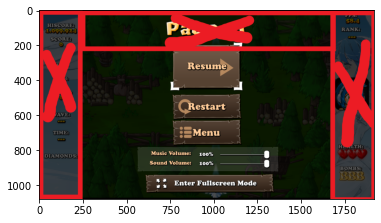

In [45]:
# If you'd like to optimize memory, use the effective X and Y action space, that is, the screen area where the actions really take place.

example = plt.imread("D:/SerpentAI/datasets/current/bullet_heaven_reduced.png")
plt.imshow(example)
plt.show()

In [10]:
def preprocess_BH2(score):
    '''For the game Bullet Heaven 2'''

    score = score.replace('S', '5').replace('s', '8').replace('e', '2').replace('O', '0').replace('B', '8').replace('o', '0').replace('.', '')
    score = sub('[^0-9]', '', score)

    try:
        score = float(score)

    except ValueError:
        score = 1.0

    if score == 0:
        score = 1.0

    return score

In [6]:
class Hakisa(torch.nn.Module):

    '''
    Hakisa itself, properly optimized to use probability distribution of actions instead of vectors.

    In order to avoid pollution, Hakisa will have a single mode.

    She will receive as inputs grame frames and the previous cumulative reward and, in the end, will generate 4 outputs:

        output 1: a tuple of probability distributions (possible_command_types, possible_actions1, possible_actions2),
        each one with sizes (Batch, len(command))

        output 2: a tuple of true action, that is, the action selected to be executed (command_type, action1, action2),
        each one with sizes (Batch, 1).

        output 3: sum of the average of rewards that can be obtained through each action

            output3 = avg_reward(command_type) + avg_reward(action1) + avg_reward(action2)

            Note that this approach is not mathematically correct and will provide a different result
            than it would if the model predicted the reward for every possible option.
            The deviation tend to be low when the reward is low, but it gets greater as the reward increases:

                27 possible actions, sum of rewards = 344 ---> mean = 12.74
                output3 = 12.63
                deviation = 0.11

                sum of rewards = 34,400,000 ---> mean = 1,274,000
                output3 = 1,263,000
                deviation = 11,000

        output 4: the predicted reward for the true action
    '''

    def __init__(self, command_types, actions1, actions2, epsilon):

        super(Hakisa, self).__init__()

        self.command_types = len(command_types)
        self.actions1 = len(actions1)
        self.actions2 = len(actions2)
        self.epsilon = epsilon # Used to determine whether to explore or simply select the best action.
        # This method is more used in Q-Learning, but can be used in Actor-Critic as well.

        # Sticking to the traditional approach first. We might use Attention Layers if those are indeed effective.

        self.conv1 = torch.nn.Conv2d(3, 100, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(100)
        self.conv2 = torch.nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1, bias=False) # 200x200
        self.batchnorm2 = torch.nn.BatchNorm2d(100)
        # Add pool 2x2 ---> 100x100
        self.conv3 = torch.nn.Conv2d(100, 200, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm3 = torch.nn.BatchNorm2d(200)
        self.conv4 = torch.nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm4 = torch.nn.BatchNorm2d(200)
        # Add pool 2x2 ---> 50x50
        self.conv5 = torch.nn.Conv2d(200, 400, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm5 = torch.nn.BatchNorm2d(400)
        self.conv6 = torch.nn.Conv2d(400, 400, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm6 = torch.nn.BatchNorm2d(400)
        # Add pool 2x2 ---> 25x25
        self.conv7 = torch.nn.Conv2d(400, 800, kernel_size=4, stride=1, bias=False) # 22x22
        self.batchnorm7 = torch.nn.BatchNorm2d(800)
        self.conv8 = torch.nn.Conv2d(800, 800, kernel_size=3, stride=1, bias=False) # 20x20
        self.batchnorm8 = torch.nn.BatchNorm2d(800)
        # Add pool 2x2 ---> 10x10
        self.conv9 = torch.nn.Conv2d(800, 1000, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm9 = torch.nn.BatchNorm2d(1000)
        self.conv10 = torch.nn.Conv2d(1000, 1000, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm10 = torch.nn.BatchNorm2d(1000)
        # Add pool 2x2 ---> 5x5

        self.neuron_in = torch.nn.Linear(1000*5*5, 100, bias=False) # Bottleneck layer.

        if self.command_types > 1:

            self.neuron_command_type = torch.nn.Linear(100, self.command_types, bias=False)

            # Considering the command type that has been predicted, what should be action1 and action2?

            self.neuron_action1 = torch.nn.Linear(100+1, self.actions1, bias=False)
            self.neuron_action2 = torch.nn.Linear(100+1, self.actions2, bias=False)

        else: # The command type index is always 0

            self.neuron_action1 = torch.nn.Linear(100, self.actions1, bias=False)
            self.neuron_action2 = torch.nn.Linear(100, self.actions2, bias=False)

        self.pred_reward_command_type = torch.nn.Linear(100+1+self.command_types, 1, bias=False)
        self.pred_reward_action1 = torch.nn.Linear(100+1+self.actions1, 1, bias=False)
        self.pred_reward_action2 = torch.nn.Linear(100+1+self.actions2, 1, bias=False)

        self.pool2x2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.LRelu = torch.nn.LeakyReLU(0.25)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, input_frame, previous_cumulative_reward):

        x = self.conv1(input_frame)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv3(x)
        x = self.batchnorm4(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv7(x)
        x = self.batchnorm7(x)
        x = self.conv8(x)
        x = self.batchnorm8(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv9(x)
        x = self.batchnorm9(x)
        x = self.conv10(x)
        x = self.batchnorm10(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = x.view(x.size(0), -1)

        x = self.neuron_in(x) # (Batch, 100). Since we're capturing a single frame at time, our Batch = 1.
        # If we were running more game instances in parallel, our Batch would be equal to the number of game instances.

        if self.command_types > 1:

            possible_command_types = self.neuron_command_type(x) # (Batch, n_command_types)
            possible_command_types = self.softmax(possible_command_types)

            # Sampling command type to determine the actions
            if torch.rand((1,)) < self.epsilon:
                #true_command_type = torch.randint(0, self.command_types, (possible_command_types.size(0), 1), device=device)
                #one_hot = torch.zeros_like(possible_command_types, device=device)
                #one_hot[:, true_command_type] = 1.
                one_hot = torch.zeros_like(possible_command_types, device=device)
                one_hot[:, torch.multinomial(possible_command_types, 1, replacement=True).item()] = 1.
                true_command_type = possible_command_types * one_hot
                true_command_type = torch.sum(true_command_type, dim=-1, keepdim=True)
            
            else: # We can't use .argmax() directly as this detaches the tensor's graphs, since argmax isn't differentiable.

                one_hot = torch.zeros_like(possible_command_types, device=device)
                one_hot[:, possible_command_types.argmax(-1)] = 1.
                true_command_type = possible_command_types * one_hot
                true_command_type = torch.sum(true_command_type, dim=-1, keepdim=True)

            y = torch.cat((x, true_command_type), -1) # (Batch, 100+1)
            possible_actions1 = self.neuron_action1(y)
            possible_actions1 = self.softmax(possible_actions1)
            possible_actions2 = self.neuron_action2(y)
            possible_actions2 = self.softmax(possible_actions2)

        else:
            possible_command_types = torch.zeros((x.size(0), 1), device=device)
            possible_actions1 = self.neuron_action1(x)
            possible_actions1 = self.softmax(possible_actions1)
            possible_actions2 = self.neuron_action2(x)
            possible_actions2 = self.softmax(possible_actions2)

        # Calculating possible reward for each command_type, for each action1 and for each action2

        expected_reward_ct = torch.zeros_like(possible_command_types, device=device)
        expected_reward_a1 = torch.zeros_like(possible_actions1, device=device)
        expected_reward_a2 = torch.zeros_like(possible_actions2, device=device)

        for batch in range(expected_reward_ct.size(0)):
            for action in range(self.command_types):

                y = torch.cat((x[batch], previous_cumulative_reward[batch], possible_command_types[batch]), -1) # (100+1+n_commands)
                y = self.pred_reward_command_type(y.unsqueeze(0)) # (1, 1)
                expected_reward_ct[batch, action] = y

                del y
        
        for batch in range(expected_reward_a1.size(0)):
            for action in range(self.actions1):

                y = torch.cat((x[batch], previous_cumulative_reward[batch], possible_actions1[batch]), -1)
                y = self.pred_reward_action1(y.unsqueeze(0))
                expected_reward_a1[batch, action] = y
                
                del y
        
        for batch in range(expected_reward_a2.size(0)):
            for action in range(self.actions2):

                y = torch.cat((x[batch], previous_cumulative_reward[batch], possible_actions2[batch]), -1)
                y = self.pred_reward_action2(y.unsqueeze(0))
                expected_reward_a2[batch, action] = y
                
                del y

        predicted_reward_ct = one_hot * expected_reward_ct # One-hot has the index of the chosen command_type
        predicted_reward_ct = torch.sum(predicted_reward_ct, dim=-1, keepdim=True)

        # Now, sampling the actions1 and actions2

        if torch.rand((1,)) < self.epsilon:
            #true_action1 = torch.randint(0, self.actions1, (possible_actions1.size(0), 1), device=device)
            #one_hot = torch.zeros_like(possible_actions1, device=device)
            #one_hot[:, true_action1] = 1.
            one_hot = torch.zeros_like(possible_actions1, device=device)
            one_hot[:, torch.multinomial(possible_actions1, 1, replacement=True).item()] = 1.
            true_action1 = possible_actions1 * one_hot
            true_action1 = torch.sum(true_action1, dim=-1, keepdim=True)
            
        else:
            one_hot = torch.zeros_like(possible_actions1, device=device)
            one_hot[:, possible_actions1.argmax(-1)] = 1.
            true_action1 = possible_actions1 * one_hot
            true_action1 = torch.sum(true_action1, dim=-1, keepdim=True)

        predicted_reward_a1 = one_hot * expected_reward_a1
        predicted_reward_a1 = torch.sum(predicted_reward_a1, dim=-1, keepdim=True)

        if torch.rand((1,)) < self.epsilon:
            #true_action2 = torch.randint(0, self.actions2, (possible_actions2.size(0), 1), device=device)
            #one_hot = torch.zeros_like(possible_actions2, device=device)
            #one_hot[:, true_action2] = 1.
            one_hot = torch.zeros_like(possible_actions2, device=device)
            one_hot[:, torch.multinomial(possible_actions2, 1, replacement=True).item()] = 1.
            true_action2 = possible_actions2 * one_hot
            true_action2 = torch.sum(true_action2, dim=-1, keepdim=True)
            
        else:
            one_hot = torch.zeros_like(possible_actions2, device=device)
            one_hot[:, possible_actions2.argmax(-1)] = 1.
            true_action2 = possible_actions2 * one_hot
            true_action2 = torch.sum(true_action2, dim=-1, keepdim=True)

        one_hot = torch.zeros_like(possible_actions2, device=device)
        one_hot[:, possible_actions2.argmax(-1)] = 1
        predicted_reward_a2 = one_hot * expected_reward_a2
        predicted_reward_a2 = torch.sum(predicted_reward_a2, dim=-1, keepdim=True)

        predicted_reward = predicted_reward_ct + predicted_reward_a1 + predicted_reward_a2

        expected_reward_ct = torch.mean(expected_reward_ct)
        expected_reward_a1 = torch.mean(expected_reward_a1)
        expected_reward_a2 = torch.mean(expected_reward_a2)

        expected_reward = expected_reward_ct + expected_reward_a1 + expected_reward_a2

        possible_actions = (possible_command_types, possible_actions1, possible_actions2)

        true_action = (true_command_type, true_action1, true_action2)

        return possible_actions, true_action, predicted_reward, expected_reward

    def execute_command(self, command):
        '''
        Command must be a tuple(command_type, action1, action2), where:

            command_type: key(keyboard) or move, rightClick, click(mouse)
            action1: Up, Down, press(keyboard), X coordinate(mouse) or None(no mouse movement)
            action2: 'a', 'z', 'shift'...(keyboard), Y coordinate(mouse) or None(no mouse movement)

        Make sure all key actions(action2) are lowered.

        Have in mind that Hakisa might output command_type 'key' and action1 that is equivalent to a mouse action.
        In this case, the command is ignored.
        '''

        if "key" in command[0]:

            try:
                
                if "Up" in command[1]:

                    try:
                        #pyautogui.keyUp(command[2])
                        keyboard.release(command[2])
                
                    except:
                        pass # If Hakisa predicts a mouse action for a keyboard command, she won't do anything.

                elif "Down" in command[1]:

                    try:
                        #pyautogui.keyDown(command[2])
                        keyboard.press(command[2])

                    except:
                        pass

                elif "press" in command[1]:

                    try:
                        keyboard.send(command[2]) # Some games won't work with pyautogui.press(), so use keyboard module, since we'll import it for Play Mode.
                    
                    except:
                        pass

                else:
                    pass
            
            except:

                pass # If Hakisa predicts a keyboard command, but outputs a mouse action, she won't do anything.

        elif "move" in command[0]:

            try:
                #pyautogui.moveTo(command[1], command[2], duration=0.19) # Duration = 0.19 seconds to be more realistic
                mouse.move(command[1], command[2], duration=0.1)

            except:
                pass # If Hakisa predict a mouse command, but outputs a keyboard action, she won't do anything.

        elif "rightclick" in command[0]:
            
            try:
                mouse.move(command[1], command[2], duration=0.1)
                mouse.right_click()
            except:
                pass

        elif "click" in command[0]:

            try:
                #pyautogui.moveTo(command[1], command[2], duration=0.19)
                mouse.move(command[1], command[2], duration=0.1)
                mouse.click() # Same case as press. Use mouse module.
            except:
                pass

        else:

            raise ValueError # It was probably you who made a mistake.

In [7]:
hakisa = Hakisa(command_types, actions1, actions2, epsilon=0.2).to(device)

In [ ]:
# Around 38,000,000 parameters. Considerable, but less than 1/3 of VGG19. Yet it's the double of ResNet parameters.
from torchsummary import summary

summary(hakisa, input_size=[(3, 200, 200), (1,)])

In [142]:
frame = torch.randn((1, 3, 200, 200), device=device)
reward = torch.zeros((1, 1), device=device)

possible_actions, true_action, predicted_reward, expected_reward = hakisa(frame, reward)

print(possible_actions[0])
print(possible_actions[1])
print(possible_actions[1].size())
print(possible_actions[2])
print(possible_actions[2].size())
print(true_action[0]) # This one actually gives the probability of the true action.
print(true_action[0].size())
print((possible_actions[0] == true_action[0]).nonzero(as_tuple=True)[1]) # This is the index, what we really want
# Attention: If true_action[N] is an integer (exploration, epsilon), true_action[N] will have size ([0])
# and this operation will return an empty tensor
print((possible_actions[1] == true_action[1]).nonzero(as_tuple=True)[1])
print(true_action[1].size())
print((possible_actions[2] == true_action[2]).nonzero(as_tuple=True)[1])
print(true_action[2].size())
print(predicted_reward)
print(expected_reward)

tensor([[0.2557, 0.3499, 0.3944]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0007, 0.0006, 0.0002,  ..., 0.0004, 0.0005, 0.0009]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1918])
tensor([[0.0010, 0.0007, 0.0009,  ..., 0.0003, 0.0008, 0.0013]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1078])
tensor([[0.3944]], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([1, 1])
tensor([2], device='cuda:0')
tensor([1315], device='cuda:0')
torch.Size([1, 1])
tensor([563], device='cuda:0')
torch.Size([1, 1])
tensor([[0.3649]], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


In [8]:
# Initializing Hakisa weights: https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/ - Item 2
torch.nn.init.orthogonal_(hakisa.neuron_in.weight, np.sqrt([2]).item())
torch.nn.init.orthogonal_(hakisa.neuron_command_type.weight, 0.01)
torch.nn.init.orthogonal_(hakisa.neuron_action1.weight, 0.01)
torch.nn.init.orthogonal_(hakisa.neuron_action2.weight, 0.01)
torch.nn.init.orthogonal_(hakisa.pred_reward_command_type.weight, 1)
torch.nn.init.orthogonal_(hakisa.pred_reward_action1.weight, 1)
torch.nn.init.orthogonal_(hakisa.pred_reward_action2.weight, 1)

Parameter containing:
tensor([[-0.0184,  0.0294, -0.0458,  ..., -0.0446, -0.0271, -0.0677]],
       device='cuda:0', requires_grad=True)

In [78]:
import os

images_by_order = []

for directory, _, files in os.walk("D:/Python/Projects/Hakisa/Hakisa/BH_gameplay"):

    for file in files:

        file = file.split('.')
        file = file[0] # Getting exclusively the number

        images_by_order.append(file)

images_by_order = sorted([int(x) for x in images_by_order])

# Problem: for strings, Python considers that 1000 < 2. Maybe something related to how the string is assembled?

images_data = []

for i in images_by_order[0:10]: # 10 samples for testing

    i = directory + '/' + str(i) + '.png'
    image = Image.open(i)
    image = image.resize((200, 200))
    array = np.array(image, dtype=np.float32)
    image.close()
    array = array/255 # Note that the data must be within [0, 1] for matplotlib.
    images_data.append(array)

images_data = np.stack(images_data, 0)

In [79]:
images_data = torch.from_numpy(images_data)
images_data = images_data.view(images_data.size(0), images_data.size(3), images_data.size(1), images_data.size(2))
print(images_data.size())

torch.Size([10, 3, 200, 200])


In [82]:
'''
command_types = ['move', 'click', 'rightclick']
                    0,      1,         2
actions1 = [i for i in range(1, 1919)]
                             0, 1918
actions2 = [i for i in range(1, 1079)]
                             0, 1078
'''

labels = [
    (0, 541, 1050), (0, 860, 972), (0, 900, 1011), (0, 738, 999), (0, 541, 1001), (0, 721, 888), (0, 781, 954), (0, 541, 1050), (0, 222, 555), (0, 541, 1050)
]

In [83]:
dataset.create_data(data=images_data, commands=labels)

All done! Use Hakisa in the Study Mode to properly train her Policy Network(mapping states to certain actions)


In [92]:
# Study Phase, or Supervised Learning Phase. What matters here is making Hakisa correlate state to commands

'''
"In SL training, we found a learning rate of 1e-4 and 10 training epochs achieve the
best result. The best model achieves a 0.15 win rate against the level-1 built-in AI. Note
that though this result is not as good as that we acquire in the HRL method, the training
here faces 564 actions, thus is much difficult. The 1e-4 learning rate is also selected by
experiments and is different from the default 1e-3 in the AlphaStar pseudocodes. We find
that training more than 10 epochs will easily fall in overfitting, making the agent can’t do
any meaningful things." - Ruo-Ze Liu et al. On Efficient Reinforcement Learning for Full-length Game of StarCraft II
'''

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.Adam(hakisa.parameters(), lr=1e-4, eps=1e-8)

losses = []
action_grads = []
policy_loss = torch.nn.CrossEntropyLoss()

dummy_reward = torch.zeros((1, 1), device=device) # Don't worry about the reward. It won't be used during the Study Phase.

grad_clip = None
save_path = None
EPOCHS = 100

In [94]:
for epoch in range(EPOCHS):

    for i, (frame, encoded_command_type, encoded_action1, encoded_action2) in enumerate(dataloader):

        hakisa.zero_grad()

        frame = frame.to(device)
        encoded_command_type = encoded_command_type.to(device)
        encoded_action1 = encoded_action1.to(device)
        encoded_action2 = encoded_action2.to(device)

        possible_actions, true_action, predicted_reward, expected_reward = hakisa(frame, dummy_reward)

        # Deleting Agent variables. Remember that our goal is to pretrain the Policy("Vectorizer")
        del true_action, predicted_reward, expected_reward
        
        command_type_loss = policy_loss(possible_actions[0], encoded_command_type)
        action1_loss = policy_loss(possible_actions[1], encoded_action1)
        action2_loss = policy_loss(possible_actions[2], encoded_action2)

        total_loss = command_type_loss + action1_loss + action2_loss

        total_loss.backward()

        action_grads.append(torch.mean(hakisa.neuron_in.weight.grad))

        optimizer.step()

    if epoch % (EPOCHS*0.1) == 0:

        print(f"{epoch}/{EPOCHS}\nCurrent Loss: {total_loss.item()}\tGradients Average: {action_grads[-1]}")
        print(f"Command Type Loss: {command_type_loss.item()}\nAction 1 Loss: {action1_loss.item()}\nAction 2 Loss: {action2_loss.item()}")

0/100
Current Loss: 15.094781875610352	Gradients Average: -4.266376549821871e-07
Command Type Loss: 0.5526037812232971
Action 1 Loss: 7.559130668640137
Action 2 Loss: 6.983047008514404


KeyboardInterrupt: 

In [97]:
print(action_grads)

[tensor(-4.2731e-05, device='cuda:0'), tensor(-3.8990e-05, device='cuda:0'), tensor(-3.6605e-05, device='cuda:0'), tensor(-2.4938e-05, device='cuda:0'), tensor(-1.4405e-05, device='cuda:0'), tensor(-7.4729e-06, device='cuda:0'), tensor(-6.1365e-06, device='cuda:0'), tensor(-1.9351e-06, device='cuda:0'), tensor(-2.3902e-06, device='cuda:0'), tensor(-4.2664e-07, device='cuda:0'), tensor(-5.1998e-06, device='cuda:0'), tensor(-1.4062e-06, device='cuda:0'), tensor(-9.7945e-06, device='cuda:0'), tensor(-3.7708e-05, device='cuda:0'), tensor(-6.7642e-06, device='cuda:0'), tensor(-1.5720e-07, device='cuda:0'), tensor(6.9483e-07, device='cuda:0'), tensor(2.9408e-06, device='cuda:0'), tensor(7.7213e-07, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-3.9997e-05, device='cuda:0'), tensor(3.1017e-07, device='cuda:0'), tensor(3.7679e-06, device='cuda:0'), tensor(4.9148e-07, device='cuda:0'), tensor(5.4101e-07, device='cuda:0'), tensor(1.3706e-07, device='cuda:0'), tensor(5.4834e-07, devi

In [11]:
# Playthrough Phase, or Reinforcement Learning Phase, where the magic really happens.
'''
"The Supervised Learning trained model has a natural “domain shift” to the RL environment.
The model of high Supervised Learning accuracy may not behave well in the RL domain"
'''

reward = torch.zeros((1, 1), device=device) # Cumulative reward
steps = 0
save_point = 10 # Also optimization point
action_grads = []
reward_grads = []

optimizer = torch.optim.Adam(hakisa.parameters(), lr=1e-4, eps=1e-8) # 1e-4 is a common LR. But 1e-6 is also used by RainbowDQN and it's the best one for HierNet
# Note: PPO also uses epsilon = 1e-5, but it seems that eps=1e-7 or 1e-8 are better.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.1) # The learning rate should decay linearly until it vanishes

value_criterion = torch.nn.HuberLoss(delta=100)
# If |predicted_reward - true_reward| > delta, use Mean Absolute Error(L1 Loss). Otherwise, Mean Squared Error.

In [13]:
sleep(5)

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)


#while keyboard.is_pressed('esc') == False: # Exit loop when Esc is pressed
while steps < 150:

    frame = dataset._grab_frame()
    frame = frame/255

    reward_input = reward.clone() # To avoid issues with inplace operations

    possible_actions, true_action, predicted_reward, expected_reward = hakisa(frame, reward_input)

    del frame

    true_command_type = (possible_actions[0] == true_action[0]).nonzero(as_tuple=True)[1].item()
    true_action1 = (possible_actions[1] == true_action[1]).nonzero(as_tuple=True)[1].item()
    true_action2 = (possible_actions[2] == true_action[2]).nonzero(as_tuple=True)[1].item()

    command = dataset.get_command(true_command_type, true_action1, true_action2)

    hakisa.execute_command(command)

    score = dataset.get_consequences(180, 1, 249-1, 213-180, tesseract_config='--psm 8')

    score = preprocess_BH2(score)

    try:

        reward += np.log10([score]).item()
    
    except:

        reward += 0.0

    reward = torch.tensor(reward, device=device)

    advantage = predicted_reward - expected_reward
    
    try:
        one_hot = torch.zeros_like(possible_actions[0], device=device)
        one_hot[0, possible_actions[0].argmax(-1)] = 1.
        possible_command_type = possible_actions[0] * one_hot
        possible_command_type = torch.sum(possible_command_type, dim=-1)

        one_hot = torch.zeros_like(possible_actions[1], device=device)
        one_hot[0, possible_actions[1].argmax(-1)] = 1.
        possible_action1 = possible_actions[1] * one_hot
        possible_action1 = torch.sum(possible_action1, dim=-1)

        one_hot = torch.zeros_like(possible_actions[2], device=device)
        one_hot[0, possible_actions[2].argmax(-1)] = 1.
        possible_action2 = possible_actions[2] * one_hot
        possible_action2 = torch.sum(possible_action2, dim=-1)

        ratio_command_type = possible_command_type/previous_possible_command_type
        ratio_action1 = possible_action1/previous_possible_action1
        ratio_action2 = possible_action2/previous_possible_action2

        ratio_command_type = torch.clamp(ratio_command_type, min=0., max=0.2)
        ratio_action1 = torch.clamp(ratio_action1, min=0., max=0.2)
        ratio_action2 = torch.clamp(ratio_action2, min=0., max=0.2)

        surrogate_loss_command_type = ratio_command_type * advantage
        surrogate_loss_action1 = ratio_action1 * advantage
        surrogate_loss_action2 = ratio_action2 * advantage

        total_surrogate_loss = surrogate_loss_command_type + surrogate_loss_action1 + surrogate_loss_action2

        value_loss = value_criterion(predicted_reward, reward)

        total_loss = total_surrogate_loss + (value_loss * 0.5)

        total_loss.backward()

    except:
        pass

    try:
        action_grads.append(torch.mean(hakisa.neuron_in.weight.grad))
        reward_grads.append(torch.mean(hakisa.pred_reward_command_type.weight.grad))
    
    except:
        pass

    previous_possible_command_type = possible_command_type.detach()
    previous_possible_action1 = possible_action1.detach()
    previous_possible_action2 = possible_action2.detach()

    steps += 1

    if steps % save_point == 0:

        optimizer.step()
        scheduler.step()

        hakisa.zero_grad()

        print(f"Current step: {steps}")
        print(f"Current Loss: {total_loss.item()}")
        print(f"Surrogate Loss: {total_surrogate_loss.item()}\tValue Loss: {value_loss.item()}\tAdvantage: {advantage.item()}")
        print(f"Command Type loss: {surrogate_loss_command_type.item()}\tRatio: {ratio_command_type.item()}")
        print(f"Action1 loss: {surrogate_loss_action1.item()}\tRatio: {ratio_action1.item()}")
        print(f"Action2 loss: {surrogate_loss_action2.item()}\tRatio: {ratio_action2.item()}")
        print(f"Predicted Reward: {predicted_reward.item()}\tCurrent Reward: {reward.item()}")
        print(command)

        '''torch.save({
            'Steps': steps,
            'Hakisa_params': hakisa.state_dict(),
            'Hakisa_LR': scheduler.get_last_lr()[0]
        }, f"{save_path}/Hakisa_checkpoint.tar")'''


        winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

C:\Users\giova\AppData\Local\Temp/ipykernel_14888/1779372183.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, device=device)


Current step: 130
Current Loss: 432.4776306152344
Surrogate Loss: 0.0	Value Loss: 864.9552612304688	Advantage: 0.0
Command Type loss: 0.0	Ratio: 0.20000000298023224
Action1 loss: 0.0	Ratio: 0.20000000298023224
Action2 loss: 0.0	Ratio: 0.20000000298023224
Predicted Reward: 292.4244689941406	Current Reward: 334.01666259765625
('rightclick', 1473, 429)
Current step: 140
Current Loss: 55.25264358520508
Surrogate Loss: 0.0	Value Loss: 110.50528717041016	Advantage: 0.0
Command Type loss: 0.0	Ratio: 0.20000000298023224
Action1 loss: 0.0	Ratio: 0.20000000298023224
Action2 loss: 0.0	Ratio: 0.20000000298023224
Predicted Reward: 339.44073486328125	Current Reward: 354.3071594238281
('rightclick', 1275, 429)
Current step: 150
Current Loss: 302.39404296875
Surrogate Loss: 0.0	Value Loss: 604.7880859375	Advantage: 0.0
Command Type loss: 0.0	Ratio: 0.20000000298023224
Action1 loss: 0.0	Ratio: 0.20000000298023224
Action2 loss: 0.0	Ratio: 0.20000000298023224
Predicted Reward: 359.353271484375	Current Re

In [147]:
print(expected_reward)
print(predicted_reward)
print(advantage)

tensor(15.2571, device='cuda:0', grad_fn=<AddBackward0>)
tensor([[15.2571]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<SubBackward0>)


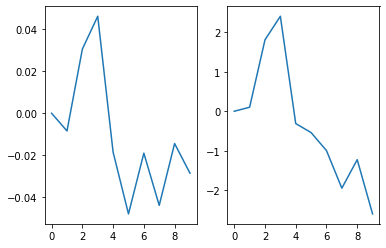

In [148]:
_, ax = plt.subplots(1, 2)

ax[0].plot(action_grads[:100])
ax[1].plot(reward_grads[:100])
plt.show()